In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import log_loss
from sklearn.calibration import calibration_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
DATA = pd.read_csv(r"C:/shoot/SHOOTS3.csv" , encoding = "CP949" , sep=",")
DATA.head()

,assist,asx,asy,fin,hed,inv,nom,res,x,y
0,0,0.0,0.0,0,0,18,1,0,0.810456,0.401598
1,0,0.0,0.0,0,1,4,0,0,0.876681,0.497257
2,0,0.0,0.0,0,0,12,1,0,0.735775,0.395596
3,0,0.0,0.0,0,0,2,1,1,0.870968,0.551670
4,0,0.0,0.0,0,1,11,0,0,0.924941,0.417424


In [3]:
DATA.dtypes

assist      int64
asx       float64
asy       float64
fin         int64
hed         int64
inv         int64
nom         int64
res         int64
x         float64
y         float64
dtype: object

#### 데이터셋 Train , Test 분리 - 학습 80%

In [4]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(
DATA.drop('res', axis=1) , DATA['res'] , random_state = 0 , shuffle=False,test_size = 0.2 )
print("X_train : " , X_train.shape)
print("y_train : " , y_train.shape)
print("X_test : " , X_test.shape)
print("y_test : " , y_test.shape)

X_train :  (228375, 9)
y_train :  (228375,)
X_test :  (57094, 9)
y_test :  (57094,)


#### 로지스틱 분류 최적 파라미터 찾기

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_1=make_pipeline(LogisticRegression(max_iter=500))
grid_values = [{'logisticregression__C': [0.001,0.01,0.1,1,3,5,7,10,100,200]}]

In [6]:
grid_1 = GridSearchCV(pipe_1, param_grid = grid_values,scoring = 'f1',verbose=1, cv=5)

In [7]:
grid_1.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logisticregression',
                                        LogisticRegression(max_iter=500))]),
             param_grid=[{'logisticregression__C': [0.001, 0.01, 0.1, 1, 3, 5,
                                                    7, 10, 100, 200]}],
             scoring='f1', verbose=1)

In [8]:
print(grid_1.best_score_)
print(grid_1.best_params_)

0.37686442124512115
{'logisticregression__C': 200}


##### 최적 파라미터로 학습

In [9]:
logres = LogisticRegression(max_iter=500 , C = 200)
logres.fit(X_train, y_train)

LogisticRegression(C=200, max_iter=500)

##### 훈련, 테스트 세트 log loss , roc auc 점수 파악

In [10]:
train_y_hat=logres.predict_proba(X_train)
logres_train_log_loss=log_loss(y_train, train_y_hat[:,1])
logres_train_roc_auc=roc_auc_score(y_train, train_y_hat[:,1])
print('훈련셋 로그손실 : ' +str(round(logres_train_log_loss, 4)))
print('훈련셋 ROC AUC : ' +str(round(logres_train_roc_auc, 3)))

훈련셋 로그손실 : 0.5753
훈련셋 ROC AUC : 0.713


In [11]:
test_y_hat=logres.predict_proba(X_test)
logres_test_log_loss=log_loss(y_test, test_y_hat[:,1])
logres_test_roc_auc=roc_auc_score(y_test, test_y_hat[:,1])
print('테스트셋 로그손실 : ' +str(round(logres_test_log_loss, 4)))
print('테스트셋 ROC AUC : ' +str(round(logres_test_roc_auc, 3)))

테스트셋 로그손실 : 0.5756
테스트셋 ROC AUC : 0.712


과적합과 같은 문제는 없는 것으로 보인다. 

##### ROC_AUC Curve

거짓양성 비율은 낮으면서 실제 양성비율이 높을 수록(왼쪽위에 근접할수록) 좋음

In [12]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_true=y_train, y_score=train_y_hat[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_true=y_test, y_score=test_y_hat[:,1])

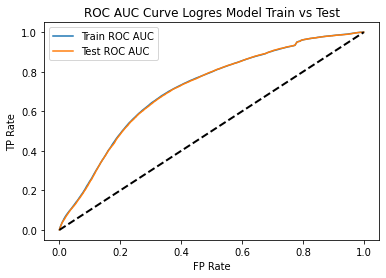

In [13]:
#close_zero = np.argmin(np.abs(test_thresholds))
plt.plot(train_fpr, train_tpr, label='Train ROC AUC')
plt.plot(test_fpr, test_tpr, label='Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
#plt.plot(train_fpr[close_zero],train_tpr[close_zero],'o',markersize=10,fillstyle='none',c='k',mew=2)
plt.legend()
plt.title('ROC AUC Curve Logres Model Train vs Test')
plt.show()

##### Calibration Curve
보정도 확인 - 예측확률과 실제확률의 관계가 45도 직선에 가까운지 파악

In [14]:
logres_ytest_prob = logres.predict_proba(X_test)[: , 1]

Text(0.5, 1.0, 'Logres Calibration Curve')

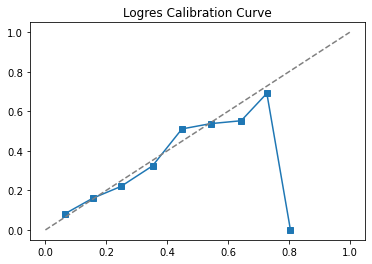

In [15]:
fraction_of_positives1, mean_predicted_values1 = calibration_curve(y_test, logres_ytest_prob, n_bins=10)
plt.plot(mean_predicted_values1, fraction_of_positives1, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title('Logres Calibration Curve')

#### 랜덤포레스트 최적 파라미터 찾기

In [16]:
from sklearn.ensemble import RandomForestClassifier
#min_samples_split - 노드분할을 위한 최소한의 샘플 데이터 수. 적을 수록 과적합 증가
#min_samples_leaf - 불균형데이터일 수록 작게 설정
#max_features - 최적분할을 위해 고려할 최대 Feature 개수 default -> sqrt(피쳐수)
#max_depth - 트리 복잡도

pipe_2 = make_pipeline(RandomForestClassifier(n_estimators=200))
grid_values_2 = [{'randomforestclassifier__max_features': [3,5,7,9], 'randomforestclassifier__max_depth':[6,8,10,20.30]}]
grid_2 = GridSearchCV(pipe_2, param_grid = grid_values_2,scoring = 'f1',verbose=1, cv=5)

In [17]:
grid_2.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(n_estimators=200))]),
             param_grid=[{'randomforestclassifier__max_depth': [6, 8, 10, 20.3],
                          'randomforestclassifier__max_features': [3, 5, 7,
                                                                   9]}],
             scoring='f1', verbose=1)

In [18]:
print(grid_2.best_score_)
print(grid_2.best_params_)

0.6002478821502896
{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 5}


##### 최적 파라미터로 학습

In [19]:
rf = RandomForestClassifier(n_estimators=200 , max_depth=10 , max_features=5 )
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=5, n_estimators=200)

##### 훈련, 테스트 세트 log loss , roc auc 점수 파악

In [20]:
train_y_hat2=rf.predict_proba(X_train)
rf_train_log_loss=log_loss(y_train, train_y_hat2[:,1])
rf_train_roc_auc=roc_auc_score(y_train, train_y_hat2[:,1])
print('훈련셋 로그손실 : ' +str(round(rf_train_log_loss, 4)))
print('훈련셋 ROC AUC : ' +str(round(rf_train_roc_auc, 3)))

훈련셋 로그손실 : 0.478
훈련셋 ROC AUC : 0.82


In [21]:
test_y_hat2=rf.predict_proba(X_test)
rf_test_log_loss=log_loss(y_test, test_y_hat2[:,1])
rf_test_roc_auc=roc_auc_score(y_test, test_y_hat2[:,1])
print('테스트셋 로그손실 : ' +str(round(rf_test_log_loss, 4)))
print('테스트셋 ROC AUC : ' +str(round(rf_test_roc_auc, 3)))

테스트셋 로그손실 : 0.4909
테스트셋 ROC AUC : 0.804


도출된 확률과 실제 값과의 오차인 log loss 수치가 여전이 낮지 않지만 사실 상관없다.
이진 분류가 아닌 확률 자체를 리턴하는 것이 목표이기 때문이다.
F1 score , Roc 수치가 로지스틱 분류 방법에 비해 개선되었다.

##### ROC_AUC Curve

In [22]:
train_fpr2, train_tpr2, train_thresholds2 = roc_curve(y_true=y_train, y_score=train_y_hat2[:,1])
test_fpr2, test_tpr2, test_thresholds2 = roc_curve(y_true=y_test, y_score=test_y_hat2[:,1])

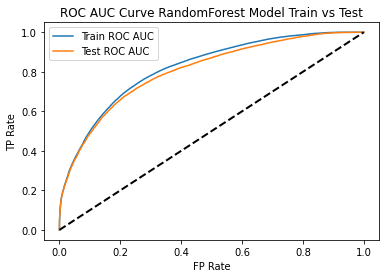

In [23]:
plt.plot(train_fpr2, train_tpr2, label='Train ROC AUC')
plt.plot(test_fpr2, test_tpr2, label='Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.legend()
plt.title('ROC AUC Curve RandomForest Model Train vs Test')
plt.show()

##### Calibration Curve

In [24]:
rf_ytest_prob = rf.predict_proba(X_test)[: , 1]

Text(0.5, 1.0, 'RandomForest Calibration Curve')

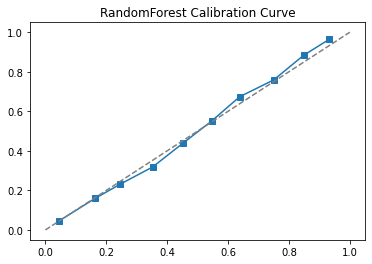

In [25]:

fraction_of_positives2, mean_predicted_values2 = calibration_curve(y_test, rf_ytest_prob, n_bins=10)
plt.plot(mean_predicted_values2, fraction_of_positives2, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title('RandomForest Calibration Curve')

Calibration Curve 가 안정적인 45도 선형을 유지하는 것을 알 수 있다.
로지스틱 분류와 비교했을 때 실제확률을 보다 잘 예측한다고 볼 수 있다.

##### Feature Importance

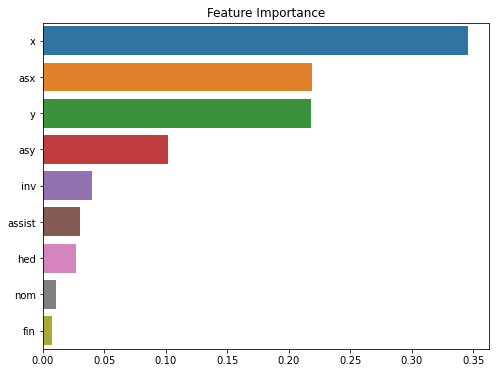

In [26]:
importances_values = rf.feature_importances_
importances = pd.Series(importances_values, index=X_train.columns)
top = importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 6))
plt.title('Feature Importance')
sns.barplot(x = top, y = top.index)
plt.show()

##### Xgboost

In [ ]:
#...

##### Precision_Recall_Curve  Logres(blue) vs Rf(red)

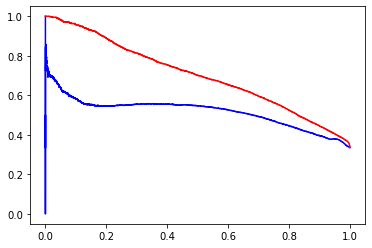

In [27]:
precisions1, recalls1, thresholds1 = metrics.precision_recall_curve(y_test, logres_ytest_prob)
precisions2, recalls2, thresholds2 = metrics.precision_recall_curve(y_test, rf_ytest_prob)
plt.plot(recalls1, precisions1, color='blue')
plt.plot(recalls2, precisions2, color='red')

##### ROC Curve Logres(blue) vs Rf(red)

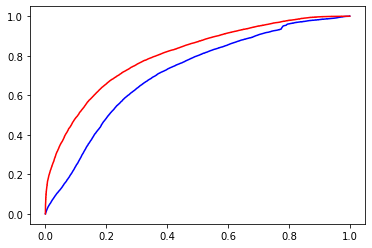

In [28]:
fprs1, tprs1, thresholds1 = metrics.roc_curve(y_test, logres_ytest_prob)
fprs2, tprs2, thresholds2 = metrics.roc_curve(y_test, rf_ytest_prob)
plt.plot(fprs1, tprs1, color='blue')
plt.plot(fprs2, tprs2, color='red')

In [29]:
from sklearn.metrics import classification_report

##### 로지스틱 분류 report 

In [30]:
pred_logres = logres.predict(X_test)
print(classification_report(y_test , pred_logres))
print("\nf1 스코어 : " , f1_score(y_test , pred_logres))

              precision    recall  f1-score   support

           0       0.71      0.88      0.79     37992
           1       0.55      0.28      0.38     19102

    accuracy                           0.68     57094
   macro avg       0.63      0.58      0.58     57094
weighted avg       0.66      0.68      0.65     57094


f1 스코어 :  0.37541907164829086


##### 랜덤포레스트  report 

Precision은 0또는1이라고 분류했을 때 실제 0 또는 1인 비율을 말한다.
recall은 실제 0또는1일 때 0 또는 1로 분류한 비율을 말한다.
report에 의하면 실제로 득점이었을 슈팅을 득점으로 분류한 비율(hit rate)은 55% 이다.

In [31]:
pred_rf = rf.predict(X_test)
print(classification_report(y_test , pred_rf))
print("\nf1 스코어 : " , f1_score(y_test , pred_rf))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83     37992
           1       0.68      0.55      0.61     19102

    accuracy                           0.76     57094
   macro avg       0.74      0.71      0.72     57094
weighted avg       0.75      0.76      0.75     57094


f1 스코어 :  0.605881500796755


우선 랜덤 포레스트 모델을 선택하고 
분류에 있어 또 다른 좋은 성능을 내는 XgBoost 방법도 향후 고려해보기로 한다.  

RandomForest - Bagging - 중복 허용 랜덤 샘플링
 
XgBoost - Boosting - 약한 예측 모형들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영 

##### Xg 결과 저장

In [32]:
##결과 저장
## assist	asx	asy	fin	hed	inv	nom	res	x	y
model_input = DATA[['assist','asx','asy','fin','hed','inv','nom','x','y']]
xG=rf.predict_proba(model_input)[:,1]
xG=np.around(xG,3)
DATA['xG']=xG
DATA.to_csv('xgresult.csv',index=False)

In [33]:
DATA.head()

,assist,asx,asy,fin,hed,inv,nom,res,x,y,xG
0,0,0.0,0.0,0,0,18,1,0,0.810456,0.401598,0.094
1,0,0.0,0.0,0,1,4,0,0,0.876681,0.497257,0.019
2,0,0.0,0.0,0,0,12,1,0,0.735775,0.395596,0.041
3,0,0.0,0.0,0,0,2,1,1,0.870968,0.551670,0.109
4,0,0.0,0.0,0,1,11,0,0,0.924941,0.417424,0.006
